In [1]:
## 1. Overview of the Data ##
import collections
import pandas as pd
import string
from sklearn.preprocessing import MinMaxScaler
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline

pll_0 = pd.read_excel("PLL schedule.xlsx", sheet_name='PLL Masterlist', header = 3)
pll = pll_0[pll_0['Categories'] == 'Precommissioning/Commissioning']

pll.columns

Index(['Owning Item', 'Package', 'Categories OLD', 'Categories',
       'Lesson Description', 'Lesson Description Mod0',
       'Lesson Description Mod', 'Cause', 'Impact / Consequences',
       'Action Title', 'Impact Level'],
      dtype='object')

In [2]:
pll['Categories'].value_counts()

Precommissioning/Commissioning    43
Name: Categories, dtype: int64

In [3]:
## 2. Tokenizing the Titles ##

tokenized_titles = []
for title in pll['Lesson Description Mod']:
    token = title.split()
    tokenized_titles.append(token)

punctuation = [",", ":", ";", ".", "'", '"', "’", "?", "/", "-", "+", "&", "(", ")"]
clean_tokenized = []

stemmer = LancasterStemmer()
 
for title in tokenized_titles:
    #lowercase = [x.lower() for x in headline]
    tokens = []
    for token in title:
        token = token.lower().strip()
        for punc in punctuation:
            token = token.replace(punc,'')
        token_stem = stemmer.stem(token)     
        tokens.append(token_stem)
        
    clean_tokenized.append(tokens)

In [4]:
clean_tokenized[0:5]

[['nuclear',
  'sourc',
  'import',
  'licens',
  'transport',
  'stor',
  'instal',
  'and',
  'commit',
  'at',
  'sit',
  'nuclear',
  'sourc'],
 ['3d',
  'vend',
  '',
  'lli',
  'shal',
  'be',
  'incorp',
  'in',
  'the',
  'main',
  '3d',
  'model'],
 ['a', 'lot', 'of', 'mot', 'fee', 'mcc', 'ar', 'not', 'prop', 'siz'],
 ['check',
  'sheet',
  'c',
  'funct',
  'test',
  'should',
  'be',
  'carry',
  'out',
  'accord',
  'to',
  'commit',
  'workflow'],
 ['chlorine',
  'emerg',
  'kit',
  'not',
  'in',
  'init',
  'spar',
  'list',
  'and',
  'the',
  'emerg',
  'proc',
  'not',
  'been',
  'train',
  'to',
  'rwtp',
  'personnel']]

In [5]:
## 3. Assembling a Matrix of Unique Words ##

import numpy as np
unique_tokens = []
single_tokens = []

for title in clean_tokenized:
    for token in title:
        if token not in single_tokens:
            single_tokens.append(token)
        elif token in single_tokens and token not in unique_tokens:
            unique_tokens.append(token)

print(len(single_tokens))
print(len(unique_tokens))

counts = pd.DataFrame(0, index=np.arange(len(clean_tokenized)), columns=unique_tokens)

296
106


In [6]:
## 4. Counting Token Occurrences ##

for row_idx, title in enumerate(clean_tokenized):
    for token in title:
        if token in unique_tokens:
            col_idx = unique_tokens.index(token)
            counts.iloc[row_idx,col_idx] += 1

In [7]:
## 5. Removing Columns to Increase Accuracy ##

word_counts = counts.sum()

print(word_counts.sort_values(ascending = False))

counts = counts.loc[:,(word_counts >= 3) & (word_counts <= 50)]

print(counts.head())

print(counts.shape)

and         16
of          16
to          16
for         12
not         12
epcc        12
the         11
commit      10
requir      10
mot          8
fail         8
with         8
be           7
at           7
comply       6
as           6
in           6
instal       6
review       6
per          5
             5
dur          5
on           5
contract     4
test         4
protect      4
phas         4
pow          4
complet      4
cabl         3
            ..
plant        2
engin        2
are          2
team         2
rwtp         2
week         2
list         2
ther         2
without      2
impl         2
instru       2
spar         2
chlorine     2
lat          2
train        2
correct      2
panel        2
up           2
precom       2
commun       2
check        2
submit       2
sheet        2
pid          2
lightn       2
pump         2
from         2
docu         2
was          2
nuclear      2
Length: 106, dtype: int64
   3d  be  commit  not  in  and  the  to  of  review ...   

In [8]:
word_counts_row = counts.sum(axis = 1)
word_counts_row[word_counts_row>5].sort_values(ascending = False)

12    18
41    15
40    14
36    14
9     14
10    12
21    11
13    10
27    10
11    10
18     9
33     9
6      9
37     8
4      7
7      7
1      7
14     7
22     7
30     7
19     6
23     6
25     6
5      6
35     6
3      6
2      6
42     6
dtype: int64

### 6. New Phase Column and see pll by phases and categories

tokenized_item = []
for item in pll["Owning Item"]:
    token = item.split('>')
    tokenized_item.append(token[3])

pll['Phase'] = tokenized_item
phases = pll.groupby(['Phase','Package','Categories']).size()
phases

In [9]:
### 7. modify columns for better accuracy

counts_cols = counts.columns.tolist()

new_col = []
for col in counts_cols:
    if len(col) > 2:
        new_col.append(col)

counts = counts[new_col]
#counts.drop(columns = ['best','practice'],axis = 1, inplace = True)
word_counts = counts.sum()
print(word_counts.sort_values(ascending = False))

and          16
for          12
epcc         12
not          12
the          11
requir       10
commit       10
fail          8
with          8
mot           8
comply        6
instal        6
review        6
per           5
dur           5
test          4
contract      4
pow           4
phas          4
complet       4
protect       4
shal          3
project       3
cod           3
prop          3
equip         3
act           3
own           3
ssp           3
build         3
process       3
sludg         3
between       3
grid          3
rcu           3
cabl          3
should        3
proc          3
conduc        3
distribut     3
coordin       3
dtype: int64


In [10]:
### 8. Convert data to boolean / binary

counts_binary = counts.astype(bool).astype(int)
counts_binary.sum().sort_values(ascending=False)

and          13
epcc         12
for          12
the          11
not          11
commit        9
requir        9
fail          8
comply        6
with          6
instal        6
mot           5
dur           5
per           5
test          4
review        4
act           3
own           3
pow           3
build         3
process       3
sludg         3
equip         3
between       3
phas          3
should        3
protect       3
prop          3
contract      3
conduc        3
shal          3
complet       3
proc          3
project       3
coordin       2
distribut     2
cabl          2
ssp           2
grid          1
rcu           1
cod           1
dtype: int64

In [11]:
### 9. Calculate similarities

from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

A_sparse = sparse.csr_matrix(counts_binary)
similarities = cosine_similarity(A_sparse)
print('pairwise dense output:\n {}\n'.format(similarities))

#also can output sparse matrices
similarities_sparse = cosine_similarity(A_sparse,dense_output=False)
print('pairwise sparse output:\n {}\n'.format(similarities_sparse))

pairwise dense output:
 [[1.         0.         0.         ... 0.40824829 0.19245009 0.        ]
 [0.         1.         0.         ... 0.25       0.23570226 0.5       ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.40824829 0.25       0.         ... 1.         0.35355339 0.5       ]
 [0.19245009 0.23570226 0.         ... 0.35355339 1.         0.23570226]
 [0.         0.5        0.         ... 0.5        0.23570226 1.        ]]

pairwise sparse output:
   (0, 35)	0.25819888974716115
  (0, 27)	0.2182178902359924
  (0, 10)	0.19245008972987526
  (0, 41)	0.19245008972987526
  (0, 37)	0.25819888974716115
  (0, 32)	0.3333333333333334
  (0, 25)	0.3333333333333334
  (0, 21)	0.4714045207910318
  (0, 19)	0.2886751345948129
  (0, 14)	0.2886751345948129
  (0, 12)	0.3651483716701108
  (0, 6)	0.25819888974716115
  (0, 4)	0.2886751345948129
  (0, 40)	0.408248290463863
  (0, 39)	0.408248290463863
  (0, 38)	0.408248290463863
  (0, 30)	0.25819888974716115
  (0, 18)	0.

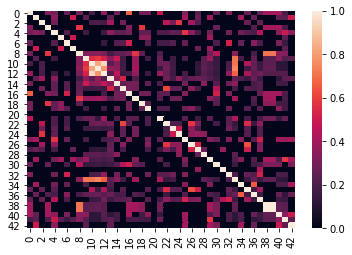

In [12]:
### 10. Convert correlation matrix into a pandas dataframe 

corrs_df = pd.DataFrame(similarities)

import seaborn as sns
sns.heatmap(corrs_df)

In [13]:
### 11. Unstack correlation matrix dataframe into series and convert it back into dataframe

corrs_series = corrs_df.unstack()
corrs_sorted = corrs_series.sort_values(ascending = False)

corrs_filtered = corrs_sorted[(corrs_sorted< 0.999) & (corrs_sorted>0.6)]
new_corrs = pd.DataFrame({'corr XY':corrs_filtered.index, 'corrs':corrs_filtered.values})

In [14]:
### 12. Clean the new correlation dataframe for sorting

index0 = new_corrs['corr XY']

parentheses = ['(',')',' ']

index1 = []
index2 = []

for index in index0:
    for punc in parentheses:
        index = str(index)
        index = index.replace(punc,'')
    corrXY = index.split(',')
    index1.append(corrXY[0])
    index2.append(corrXY[1])
    
print(index1[:5])
print(index2[:5])

new_corrs['corr X'] = index1
new_corrs['corr Y'] = index2

new_corrs.drop(columns = ['corr XY'],inplace=True)

new_corrs[['corr X','corr Y']] = new_corrs[['corr X','corr Y']].astype('int64')
new_corrs.info()
print(new_corrs.head(10))

new_corrs['corr X'].value_counts()

['12', '10', '11', '10', '12']
['10', '12', '10', '11', '11']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
corrs     26 non-null float64
corr X    26 non-null int64
corr Y    26 non-null int64
dtypes: float64(1), int64(2)
memory usage: 664.0 bytes
      corrs  corr X  corr Y
0  0.948683      12      10
1  0.948683      10      12
2  0.824958      11      10
3  0.824958      10      11
4  0.782624      12      11
5  0.782624      11      12
6  0.750000      11      33
7  0.750000      33      11
8  0.707107      38       8
9  0.707107       9      33


33    4
12    3
11    3
10    3
8     2
26    1
22    1
16    1
15    1
9     1
39    1
38    1
36    1
35    1
34    1
0     1
Name: corr X, dtype: int64

In [15]:
top_corr_X = new_corrs['corr X'].value_counts()
top_five = top_corr_X.index[0:5]

i=1

for idx in top_five:
    print('No ', i, ':\n' )
    top_first = new_corrs[new_corrs['corr X'] == idx]
    print(top_first,'\n')
    print(idx , ':', pll.iloc[top_first['corr X'].iloc[0]]['Lesson Description'],'\n')
    for top in top_first['corr Y']:
        print(top , ':', pll.iloc[top]['Lesson Description'],'\n')
    print('\n')    
    i += 1


No  1 :

       corrs  corr X  corr Y
7   0.750000      33      11
12  0.707107      33      10
13  0.707107      33       9
17  0.670820      33      12 

33 : EPCC failed to comply with power cable requirement for MOV 

11 : EPCC failed to comply with motor protection requirement (thermistor) for all their VSD motors 

10 : EPCC failed to comply with motor efficiency requirement. Got motor installed with IE1 efficiency. Project specification calls for minimum IE2 

9 : EPCC failed to comply with correct phase rotation for most of the power distribution board due to wrong termination at power feeders 

12 : EPCC failed to comply with project requirement on ELR requirement for all motors. Only motor 30KW and above are installed with ELR and ZCT 



No  2 :

       corrs  corr X  corr Y
0   0.948683      12      10
4   0.782624      12      11
16  0.670820      12      33 

12 : EPCC failed to comply with project requirement on ELR requirement for all motors. Only motor 30KW and above a

In [16]:
### 13. Run original counts without converting to binary 

counts_scaled=((counts-counts.min())/(counts.max()-counts.min()))

B_sparse = sparse.csr_matrix(counts_scaled)
B_similarities = cosine_similarity(B_sparse)
print('pairwise dense output:\n {}\n'.format(B_similarities))

#also can output sparse matrices
B_similarities_sparse = cosine_similarity(B_sparse,dense_output=False)
print('pairwise sparse output:\n {}\n'.format(B_similarities_sparse))

B_corrs_df = pd.DataFrame(B_similarities)

B_corrs_series = B_corrs_df.unstack()
B_corrs_sorted = B_corrs_series.sort_values(ascending = False)

B_corrs_filtered = B_corrs_sorted[(B_corrs_sorted< 0.999) & (B_corrs_sorted>0.6)]
B_new_corrs = pd.DataFrame({'corr XY':B_corrs_filtered.index, 'corrs':B_corrs_filtered.values})

B_index0 = B_new_corrs['corr XY']

B_index1 = []
B_index2 = []

for index in B_index0:
    for punc in parentheses:
        index = str(index)
        index = index.replace(punc,'')
    corrXY = index.split(',')
    B_index1.append(corrXY[0])
    B_index2.append(corrXY[1])
    
#print(B_index1[:5])
#print(B_index2[:5])

B_new_corrs['corr X'] = B_index1
B_new_corrs['corr Y'] = B_index2

B_new_corrs.drop(columns = ['corr XY'],inplace=True)

B_new_corrs[['corr X','corr Y']] = B_new_corrs[['corr X','corr Y']].astype('int64')
B_new_corrs.info()
#print(B_new_corrs.head(10))

B_new_corrs.groupby(['corr X']).size().sort_values(ascending=False)

pairwise dense output:
 [[1.         0.         0.         ... 0.17025131 0.1490712  0.        ]
 [0.         1.         0.         ... 0.29488391 0.25819889 0.5       ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.17025131 0.29488391 0.         ... 1.         0.38069349 0.58976782]
 [0.1490712  0.25819889 0.         ... 0.38069349 1.         0.25819889]
 [0.         0.5        0.         ... 0.58976782 0.25819889 1.        ]]

pairwise sparse output:
   (0, 35)	0.43643578047198484
  (0, 27)	0.3265986323710905
  (0, 10)	0.28426762180748066
  (0, 41)	0.14907119849998599
  (0, 37)	0.12309149097933275
  (0, 32)	0.1666666666666667
  (0, 25)	0.2357022603955159
  (0, 21)	0.48112522432468824
  (0, 19)	0.1543033499620919
  (0, 14)	0.11322770341445959
  (0, 12)	0.3872983346207417
  (0, 6)	0.09901475429766744
  (0, 4)	0.11322770341445959
  (0, 40)	0.17025130615174974
  (0, 39)	0.18257418583505539
  (0, 38)	0.18257418583505539
  (0, 30)	0.09901475429766744
  (

corr X
33    4
10    4
11    4
8     3
9     3
12    3
39    1
17    1
7     1
15    1
19    1
38    1
22    1
26    1
31    1
34    1
36    1
37    1
5     1
dtype: int64

In [17]:
B_top_corr_X = B_new_corrs['corr X'].value_counts()
B_top_five = B_top_corr_X.index[0:5]

i=1

for idx in B_top_five:
    print('No ', i, ':\n' )
    top_first = B_new_corrs[B_new_corrs['corr X'] == idx]
    print(top_first,'\n')
    print(idx , ':', pll.iloc[top_first['corr X'].iloc[0]]['Lesson Description'],'\n')
    for top in top_first['corr Y']:
        print(top , ':', pll.iloc[top]['Lesson Description'],'\n')
    print('\n')    
    i += 1


No  1 :

       corrs  corr X  corr Y
3   0.839254      33      11
6   0.817630      33       9
10  0.739574      33      10
12  0.707107      33      12 

33 : EPCC failed to comply with power cable requirement for MOV 

11 : EPCC failed to comply with motor protection requirement (thermistor) for all their VSD motors 

9 : EPCC failed to comply with correct phase rotation for most of the power distribution board due to wrong termination at power feeders 

10 : EPCC failed to comply with motor efficiency requirement. Got motor installed with IE1 efficiency. Project specification calls for minimum IE2 

12 : EPCC failed to comply with project requirement on ELR requirement for all motors. Only motor 30KW and above are installed with ELR and ZCT 



No  2 :

       corrs  corr X  corr Y
0   0.935819      10      12
5   0.834847      10      11
11  0.739574      10      33
33  0.603023      10       9 

10 : EPCC failed to comply with motor efficiency requirement. Got motor installed wit

In [18]:
counts_scaled

,commit,not,and,the,review,contract,shal,test,epcc,for,...,between,equip,sludg,process,build,ssp,own,act,grid,cod
0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
counts_binary

,commit,not,and,the,review,contract,shal,test,epcc,for,...,between,equip,sludg,process,build,ssp,own,act,grid,cod
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
7,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
